In [1]:
import torch

# To resolve memory leaks giving received 0 items from anecdata
# Reference link https://github.com/pytorch/pytorch/issues/973
torch.multiprocessing.set_sharing_strategy("file_system")
from torch.utils.data import DataLoader
import sys
# sys.path.append("/fsx-repligen/piyusht1/projects/uCO3D/uco3d/")
sys.path.append("../../uco3d/")
from uco3d.uco3d_dataset import UCO3DDataset, UCO3DFrameDataBuilder
from uco3d.dataset_utils.scene_batch_sampler import (
    SceneBatchSampler,
)


from pytorch3d.renderer.cameras import PerspectiveCameras





A few examples of Arguments which can be given to the dataset constructor. Replace DATASET_ROOT with the folder where the dataset videos/point_clouds/cameras exist. 

In [2]:
DATASET_ROOT = "/fsx-repligen/shared/datasets/uCO3D/batch_reconstruction/dataset_export"
# METADATA_FILE = os.path.join(DATASET_ROOT, "metadata_1766.sqlite")
METADATA_FILE = "/fsx-repligen/shared/datasets/uCO3D/batch_reconstruction/dataset_export/metadata_all_updated.sqlite"

NO_BLOBS_KWARGS = {
    "dataset_root": "",
    "load_images": False,
    "load_depths": False,
    "load_masks": False,
    "load_depth_masks": False,
    "box_crop": False,
    "image_height": 800,
}
SCENE_BATCH_SAMPLER_KWARGS = {
    "dataset_root": "",
    "image_height": 800,
    "image_width": 800,
    "load_depths": False,
    # "load_frames_from_videos": False,
}


Can create frame_data_builder explicitly and pass to it dataset contructor or use frame_data_builder_args and pass it to dataset constructor. frame_data_builder_args is a cleaner way to do so, and is what is used here


In [3]:
# frame_data_builder_args = NO_BLOBS_KWARGS
frame_data_builder_args = SCENE_BATCH_SAMPLER_KWARGS

frame_data_builder = UCO3DFrameDataBuilder(
    # dataset_root="/fsx-repligen/piyusht1/projects/uCO3D_SfM/export_reconstruction_2000/dataset_export",
    dataset_root=DATASET_ROOT,
    load_frames_from_videos=True,
    load_depths=True,
    image_height = 800,
    load_point_clouds=True,
)

dataset = UCO3DDataset(
    # dataset_root="/fsx-repligen/piyusht1/projects/uCO3D_SfM/export_reconstruction_2000/dataset_export",
    dataset_root="/fsx-repligen/shared/datasets/uCO3D/batch_reconstruction/dataset_export",
    sqlite_metadata_file=METADATA_FILE,
    remove_empty_masks=False,   
    frame_data_builder_args = frame_data_builder_args,
)

For sampling, can create a pytorch DataLoader object. Following is an example of Dataloading with sampler as SceneBatchSampler, which selects certain number of instances from a sequence for a batch (In this code, number of samples for a batch is set to 48, and instances per sequence are set to 8)

In [4]:
images_per_seq_options = [8]
scene_batch_sampler = SceneBatchSampler(
    dataset=dataset,
    batch_size=48,
    num_batches=1,
    images_per_seq_options=images_per_seq_options,
)

def my_collate_fn(batch):
    return [batch]

num_workers = 0
dataloader = DataLoader(
    dataset,
    batch_sampler=scene_batch_sampler,
    num_workers=num_workers,
    collate_fn=dataset.frame_data_type.collate,
)

## Example to get the batches
for i,data in enumerate(dataloader):
    print(f"Batch Number {i}")

Batch Number 0


In [24]:
sequences = dataset.sequence_names()
seq = sequences[1343]
print("Number of sequences:", len(sequences))
print("Sequence name:", seq)

# sequence_frames_in_order returns an iterator over (timestamp, frame_id, global_index)
# frame_id is unique within a sequence; global_index is unique within the dataset
# to get length, we convert it to a list
seq_frame_ids = list(dataset.sequence_frames_in_order(seq))
print("Number of frames in the sequence:", len(seq_frame_ids))
ts, frame_id, idx = seq_frame_ids[42]

Number of sequences: 152060
Sequence name: 23984-7278-35526
Number of frames in the sequence: 200


We provide two equvalent ways of indexing the dataset: by global ordinal index, and by (sequence, frame_id) pairs. dataset[idx] returns a Uco3dFrameData dataclass object that contains metadata fields such as frame_timestamp and camera pose, and tensors like image_rgb and fg_probability. dataset.meta[] accessor does not load any blobs such as image and mask – so that those fields stay None, but provides camera poses.

In [25]:
assert dataset.meta[idx].sequence_name == dataset.meta[seq, frame_id].sequence_name
assert dataset.meta[idx].frame_number == dataset.meta[seq, frame_id].frame_number
assert dataset.meta[seq, frame_id].image_rgb is None

# Use dataset[] to load the full frame data
frame = dataset[seq, frame_id]
assert frame.sequence_name == dataset.meta[seq, frame_id].sequence_name
assert frame.frame_number == dataset.meta[seq, frame_id].frame_number
assert frame.image_rgb is not None

Showing sequence 23984-7278-35526


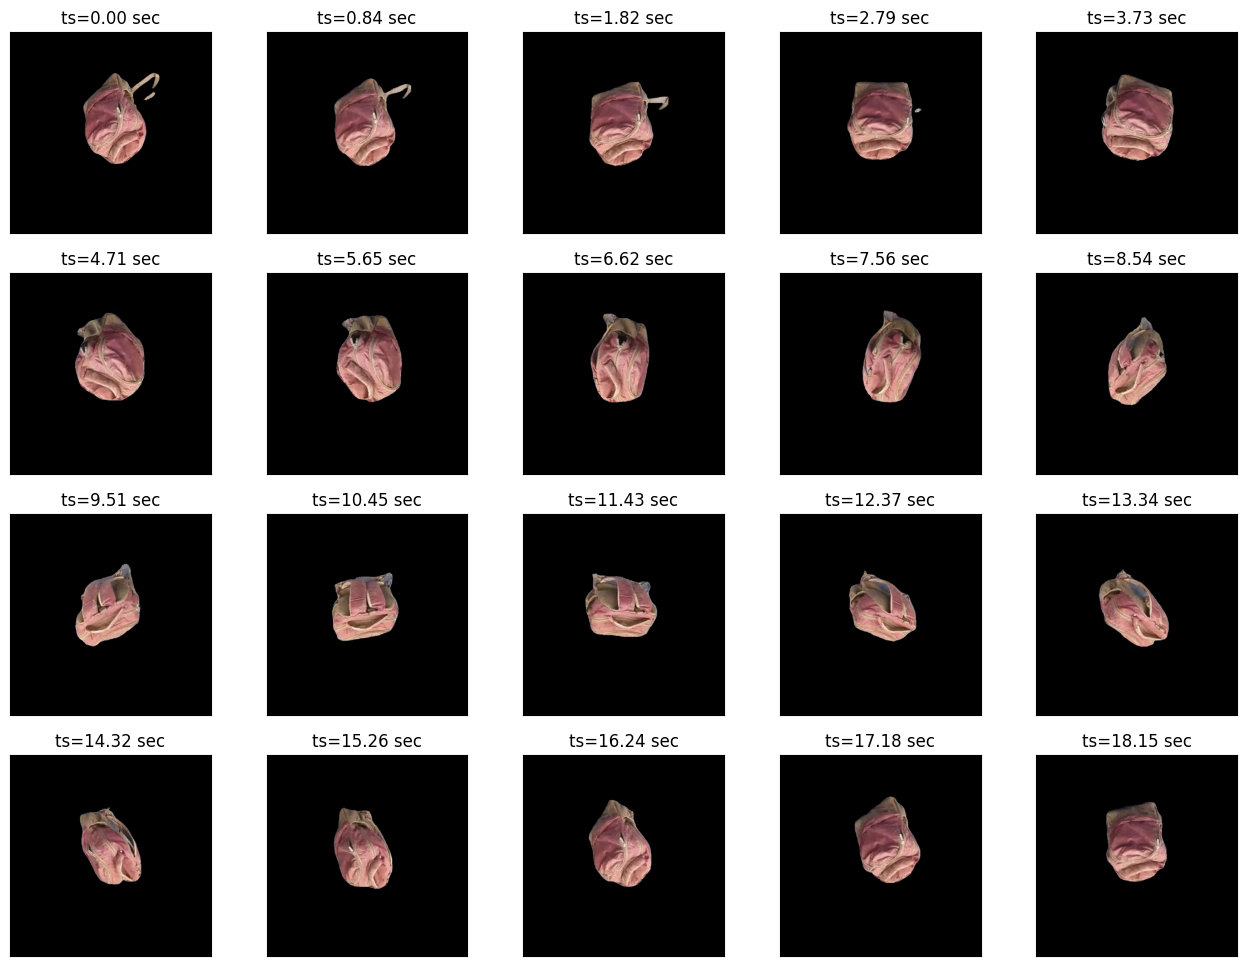

In [26]:
from pytorch3d.vis.plotly_vis import plot_scene
from IPython.display import display
from matplotlib import pyplot as plt


print("Showing sequence", seq)
n_vis_frames = 20
n_image_cols = 5
ax = plt.figure(figsize=(16, 12)).subplots(-(-n_vis_frames // n_image_cols), n_image_cols).reshape(-1)
for slot in ax:
    slot.get_xaxis().set_visible(False)
    slot.get_yaxis().set_visible(False)

interval = len(seq_frame_ids) // n_vis_frames
for slot, (_, frame_id, _) in zip(ax, seq_frame_ids[::interval]):
    frame = dataset[seq, frame_id]  # loading and cropping happens on this call
    masked_im = frame.image_rgb * frame.fg_probability
    slot.imshow(masked_im.permute(1, 2, 0).data.numpy())
    slot.set_title(f"ts={frame.frame_timestamp:.2f} sec")

#Visualize depths
visualize_depths = False
if visualize_depths:
    ax = plt.figure(figsize=(16, 12)).subplots(-(-n_vis_frames // n_image_cols), n_image_cols).reshape(-1)
    for slot in ax:
        slot.get_xaxis().set_visible(False)
        slot.get_yaxis().set_visible(False)

    interval = len(seq_frame_ids) // n_vis_frames
    for slot, (_, frame_id, _) in zip(ax, seq_frame_ids[::interval]):
        frame = dataset[seq, frame_id]  # loading and cropping happens on this call
        masked_im = frame.depth_map * frame.fg_probability
        slot.imshow(masked_im.permute(1, 2, 0).data.numpy())
        slot.set_title(f"ts={frame.frame_timestamp:.2f} sec")

plotly widget with 3D camera poses . To convert camera to pytorch3d representation, use the _get_pytorch3d_camera_from_uco3d_camera function here

In [29]:
from pytorch3d.renderer.camera_utils import join_cameras_as_batch

def _get_pytorch3d_camera_from_uco3d_camera(
    camera,
) -> PerspectiveCameras:
    assert camera is not None
    return PerspectiveCameras(
        focal_length=camera.focal_length,
        principal_point=camera.principal_point,
        R=camera.R,
        T=camera.T,
    )

cameras = join_cameras_as_batch([_get_pytorch3d_camera_from_uco3d_camera(dataset.meta[seq, frame_id].camera) for _, frame_id, _ in seq_frame_ids[::interval]])
plot_scene({"main": {"cameras": cameras}}, camera_scale=0.3)